In [1]:
from fastai.vision import *

## Data

In [2]:
bs   = 64
path = untar_data(URLs.PETS)/'images'
tfms = get_transforms(max_rotate=20,
                      max_zoom=1.3,
                      max_lighting=0.4,
                      max_warp=0.4,
                      p_affine=1.,   # Prob of affine trans happening: always
                      p_lighting=1.) # Prob of lighting trans happening: always


src  = (ImageItemList.from_folder(path)
       .random_split_by_pct(0.2, seed=2)
       .label_from_re(r'([^/]+)_\d+.jpg$'))

data = (src.transform(tfms, size=224, padding_mode='reflection')
           .databunch(bs=bs).normalize(imagenet_stats))

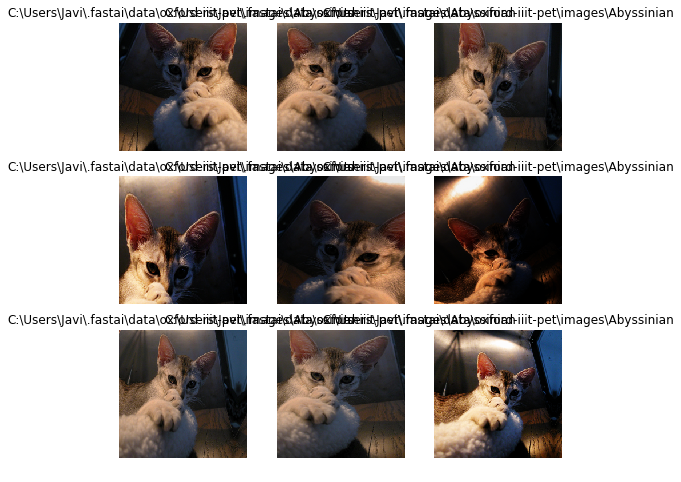

In [3]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

## Train

In [4]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [5]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.617809,1.369122,0.278755
2,1.565875,0.354519,0.083221
3,0.948213,0.291380,0.084574


In [6]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.707974,0.303819,0.073072
2,0.668609,0.296936,0.072395


In [7]:
learn.data = (src.transform(tfms, size=352, padding_mode='reflection')
             .databunch(bs=bs).normalize(imagenet_stats))

learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.626224,0.271831,0.050744
2,0.605349,0.264086,0.052097


In [8]:
learn.save('352')

## Kernel

In [5]:
data = (src.transform(tfms, size=352, padding_mode='reflection')
        .databunch(bs=16).normalize(imagenet_stats))

learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category C:\Users\Javi\.fastai\data\oxford-iiit-pet\images\american_pit_bull_terrier

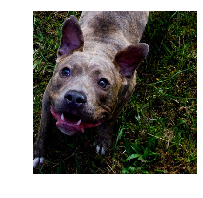

In [6]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [7]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 176, 176]   9408       False     
______________________________________________________________________
BatchNorm2d          [16, 64, 176, 176]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 176, 176]   0          False     
______________________________________________________________________
MaxPool2d            [16, 64, 88, 88]     0          False     
______________________________________________________________________
Conv2d               [16, 64, 88, 88]     36864      False     
______________________________________________________________________
BatchNorm2d          [16, 64, 88, 88]     128        True      
______________________________________________________________________
ReLU                 [16, 64, 88, 88]     0          False     
______________________________________________________________

In [8]:
from fastai.callbacks.hooks import *

In [9]:
kernel = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6 # 1 out ch, 3 in ch, 3x3 heigh-with
kernel, kernel.shape

(tensor([[[[ 0.0000, -0.2778,  0.1667],
           [-0.2778, -0.2778,  0.1667],
           [ 0.1667,  0.1667,  0.1667]],
 
          [[ 0.0000, -0.2778,  0.1667],
           [-0.2778, -0.2778,  0.1667],
           [ 0.1667,  0.1667,  0.1667]],
 
          [[ 0.0000, -0.2778,  0.1667],
           [-0.2778, -0.2778,  0.1667],
           [ 0.1667,  0.1667,  0.1667]]]]), torch.Size([1, 3, 3, 3]))

In [10]:
img = data.valid_ds[0][0].data[None]; img.shape

torch.Size([1, 3, 352, 352])

In [11]:
edge = F.conv2d(img, k); edge.shape

NameError: name 'k' is not defined

In [ ]:
show_image(edge[0], figsize=(5,5));

## Show activations features

This method shows features of all trained classes.

Final features [512, 11, 11]

In [12]:
from fastai.callbacks.hooks import *

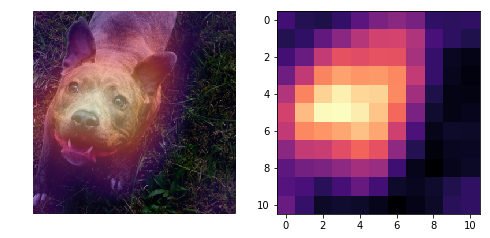

In [16]:
model  = learn.model.eval()
x,y    = data.valid_ds[0]

def get_conv_activations(model, img):
    model_backbone = model[0]  # Get only model feature extractor
    xb,_ = data.one_item(img)  # Create minibatch from image
    
    with hook_output(model_backbone) as hook_a: 
        preds = model(xb)
    
    return hook_a.stored[0].cpu() # Return a [512, 11, 11] tensor


def show_conv_activations(model, img):
    acts      = get_conv_activations(model, img)
    avg_acts  = acts.mean(0) # 512 axis mean to get a [11, 11] tensor
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    x.show(ax1)
    ax1.imshow(avg_acts, alpha=0.5, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');
    ax2.imshow(avg_acts, cmap='magma');
    
show_conv_activations(model, x)

## Show activations features BY CLASS (Grad-CAM)

[Paper: Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

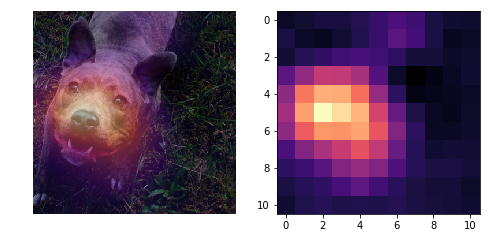

In [171]:
model  = learn.model.eval()
x,_    = data.valid_ds[0]
_,y    = data.valid_ds[0]

def get_conv_activations2(model, img, label):
    model_backbone = model[0]  # Get only model feature extractor
    xb,_ = data.one_item(img)  # Create minibatch from image
    
    with hook_output(model_backbone) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(label)].backward()
    
    return hook_a.stored[0].cpu(), hook_g.stored[0][0].cpu()


def show_conv_activations2(model, img, label):
    acts, grad = get_conv_activations2(model, img, label)
    grad_chan  = grad.mean(1).mean(1)
    mult       = (acts*grad_chan[...,None,None]).mean(0)
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    x.show(ax1)
    ax1.imshow(mult, alpha=0.5, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');
    ax2.imshow(mult, cmap='magma');
    

show_conv_activations2(model, x, y)